# An Emotion Detection model that can identify the emotion of the people leaning on the text. It can be useful for analyzing the different statistics. For example: videos from youtube, tweets during certain period, game reviews, etc

This notebook uses "Sentiment140" dataset from kaggle: https://www.kaggle.com/datasets/kazanova/sentiment140/code

The model was created by https://github.com/BohdanChuprynka

## Import libraries

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import sklearn
import kagglehub
import os

## Download the dataset

In [ ]:
# Download the dataset
root_path = os.getcwd()
path = kagglehub.dataset_download("kazanova/sentiment140")
print("Path to dataset files:", path)

csv_path = os.path.join(path, "training.1600000.processed.noemoticon.csv")
df = pd.read_csv(
    csv_path,
    encoding="latin-1",
    header=None,
    names=["target", "ids", "date", "flag", "user", "text"]
)
print(df.head(15))

Path to dataset files: /Users/bohdan/.cache/kagglehub/datasets/kazanova/sentiment140/versions/2
    target         ids                          date      flag  \
0        0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1        0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2        0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3        0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4        0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
5        0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY   
6        0  1467811592  Mon Apr 06 22:20:03 PDT 2009  NO_QUERY   
7        0  1467811594  Mon Apr 06 22:20:03 PDT 2009  NO_QUERY   
8        0  1467811795  Mon Apr 06 22:20:05 PDT 2009  NO_QUERY   
9        0  1467812025  Mon Apr 06 22:20:09 PDT 2009  NO_QUERY   
10       0  1467812416  Mon Apr 06 22:20:16 PDT 2009  NO_QUERY   
11       0  1467812579  Mon Apr 06 22:20:17 PDT 2009  NO_QUERY   
12       0  1467812723  Mon Apr 06 22:20:19 PD

# Visualizing our data

<Figure size 1000x700 with 0 Axes>

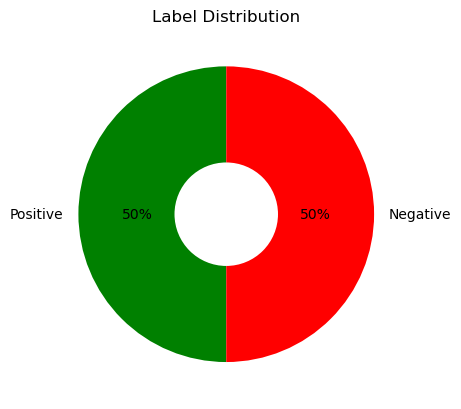

<Figure size 1000x700 with 0 Axes>

In [27]:
import matplotlib.pyplot as plt
# Count how much positives and negative is in our dataset
# 1 == positive, 0 == negative.
df_target = df["target"].replace(4, 1)

negative_values = df_target.value_counts()[0]
positive_values = df_target.value_counts()[1]

# Create a pie chart
plt.pie(
    [positive_values, negative_values],
    labels=['Positive', 'Negative'],
    autopct="%1.f%%",
    startangle=90,
    colors=['green', 'red'],
    wedgeprops=dict(width=.65),
    labeldistance=1.1
)
plt.title("Label Distribution")
plt.figure(figsize=(10, 7))

In [31]:
positive_values = df["target"].value_counts()
positive_values

target
0    800000
4    800000
Name: count, dtype: int64

In [32]:
df_1=df['target'].value_counts()
df_target=pd.DataFrame(df_1)
df_target=df_target.reset_index()
df_target.columns = ['target', 'count']
df_target['target'] = df_target['target'].apply(lambda x: 1 if x == 4 else x)

# Now df_target DataFrame will have 1 for positive tweets and 0 for negative tweets
df_target.head()

,target,count
0,0,800000
1,1,800000


In [33]:
# Take amount of random sentences, see it's label and text
def random_sentence(df, amount):
  for i in range(amount):
    random_index = random.randint(0, len(df["text"]))
    random_sentence = df["text"][random_index]
    random_label = df["target"][random_index]

    print(f"Text: {random_sentence}\nLabel: {random_label}")

random_sentence(df, 3)

Text: IDontFeelWell  &amp;Im Going To Flippin Pizza Express For Some Pizza That I Dont Want
Label: 0
Text: @royadotcom LAWL. K WHATEVER YOU ATTENTION WHORE. 
Label: 4
Text: @suttygal Hey sutty! I got one of David's tweets today on my phone, but that's it.     Did you have a nice birthday? 
Label: 4


# Preprocessing our data

Now, when we are explored our data, we are ready to preprocess it.
Before we start, it would be useful to create a list of useful functions we need to create

1. Delete HTML Tags
2. Remove Punctuatiton
3. Lowercase the text
4. Replace all the user tags to "@mention"
5. Remove duplicated spaces
6. Delete stopwords
7. Delete urls

By doing the processing of our data, we will get better accuracy while training our model.

Some functions were taken from this site by this author: https://www.kaggle.com/code/marianadeem755/exploring-twitter-sentiments-bilstm-logisticreg


In [ ]:
import string
import regex as re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# 1. Delete HTML Tags
def delete_html_tags(text):
  clean_text = re.sub(r'<.*?>', '', text)
  return clean_text

# 2. Remove Punctuatiton
def remove_punctuation(text):
  return text.translate(str.maketrans('', '', string.punctuation))

# 3. Lowercase the text
def to_lowercase(text):
  return text.lower()

# 4. Replace all the user tags to "@mention"
def remove_mention(text):
  mention_regex = r"@\w+"
  return re.sub(mention_regex, "@mention", text)

# 5. Remove duplicated spaces
def remove_duplicate_whitespace(text):
  return " ".join(text.split())

# 6. Delete stopwords
def remove_stopwords(text):
  stop_words = set(stopwords.words('english'))
  words = text.split()
  filtered_words = [word for word in words if word not in stopwords.words('english')]
  return " ".join(filtered_words)

# 7. Delete urls
def delete_url(text):
  clean_text = re.sub(r'http\S+', '', text)
  return clean_text

# Function to replace chat words
def replace_chat_words(text):
    chat_words = {
        "brb": "be right back",
        "btw": "by the way",
        "omg": "oh my goodness",
        "ttyl": "talk to you later",
        "omw": "on my way",
        "smh": "shaking my head",
        "smdh": "shaking my darn head",
        "lol": "laugh out loud",
        "tbd": "to be determined",
        "imho": "in my humble opinion",
        "imo": "in my opinion",
        "hmu": "hit me up",
        "iirc": "if I remember correctly",
        "lmk": "let me know",
        "og": "original gangsters",
        "ftw": "for the win",
        "nvm": "nevermind",
        "ootd": "outfit of the day",
        "ngl": "not gonna lie",
        "rq": "real quick",
        "iykyk": "if you know, you know",
        "ong": "on god/I swear",
        "yaaas": "yeah",
        "brt": "be right there",
        "sm": "so much",
        "ig": "i guess",
        "wya": "where you at",
        "istg": "i swear to god",
        "hbu": "how about you",
        "atm": "at the moment",
        "asap": "as soon as possible",
        "fyi": "for your information"
    }
    for shorten_word, full_word in chat_words.items():
        text = text.replace(shorten_word, full_word)
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import time

def visualize_preprocessing(sentence):
  """
  Function to visualize the preprocessing of the sentence

  Args: sample sentence from the dataset.
  """

  sentence = remove_mention(sentence)
  print(f"Mention removed: {sentence}")
  time.sleep(1)
  sentence = delete_html_tags(sentence)
  print(f"Deleted html tags:{sentence}")
  time.sleep(1)
  sentence = delete_url(sentence)
  print(f"Urls deleted: {sentence}")
  time.sleep(1)
  sentence = remove_punctuation(sentence)
  print(f"Punctuation removed: {sentence}")
  time.sleep(1)
  sentence = to_lowercase(sentence)
  print(f"Lowercase: {sentence}")
  time.sleep(1)
  sentence = replace_chat_words(sentence)
  print(f"Replaced chat-words: {sentence}")
  time.sleep(1)
  sentence = remove_stopwords(sentence)
  print(f"Removed stopwords: {sentence}")
  time.sleep(1)
  sentence = remove_duplicate_whitespace(sentence)
  print(f"Whitespaces deleted: {sentence}")
  time.sleep(1)



In [ ]:
def preprocess_text(text):
  text = delete_html_tags(text)
  text = delete_url(text)
  text = remove_mention(text)
  text = remove_punctuation(text)
  text = to_lowercase(text)
  text = replace_chat_words(text)
  text = remove_stopwords(text)
  text = remove_duplicate_whitespace(text)


  return text

df["text"] = df["text"].apply(preprocess_text)
df

In [ ]:
df.to_csv(os.path.join(root_path, "preprocessed.csv"), index=False)
del df

# Loading a data

In [ ]:
# Load the saved dataset 
preprocessed_df = pd.read_csv(os.path.join(root_path, "preprocessed.csv"))

In [34]:
# Replace positive label 4 to label 1
preprocessed_df["target"] = preprocessed_df["target"].replace(4, 1)
preprocessed_df[:-5]

NameError: name 'preprocessed_df' is not defined

In [ ]:
# Delete a columns that won't really affect our accuracy.
preprocessed_df = preprocessed_df.drop(["ids", "flag", "user", "Unnamed: 0"], axis=1)

In [ ]:
# Delete NANs

# How many NAN values are in our dataset
preprocessed_df.isnull().sum().sum()

# Drop NANs
preprocessed_df = preprocessed_df.dropna()

# More NANs? 
preprocessed_df.isnull().sum().sum()

0

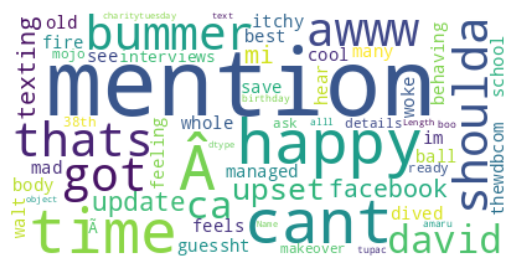

In [ ]:
# Create a wordcloud to visualize our most used words
from wordcloud import WordCloud
wordcloud = WordCloud(collocations = False, background_color = 'white').generate(str(preprocessed_df["text"]))
# Display the generated Word Cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# Split our data into train and validation sets
from sklearn.model_selection import train_test_split
train_dataset, val_dataset = train_test_split(preprocessed_df,
                                              train_size=0.3, # Drop some of the dataset since collab don't give that much cache to work
                                                              # with that much data
                                              test_size=0.01,
                                              shuffle=True)
len(train_dataset), len(val_dataset)

(479879, 15996)

In [ ]:
train_df = pd.DataFrame(train_dataset)
val_df = pd.DataFrame(val_dataset)
train_df[:10]

,target,date,text
914539,1,Sat May 09 23:21:44 PDT 2009,calling mothers calling mothersget butts bed k...
157446,0,Thu May 28 21:45:05 PDT 2009,eric ronnick looks lot like brendon uriewell s...
641367,0,Fri Jun 19 00:43:12 PDT 2009,ri guessht bathroom floor wont clean life lead
1232110,1,Mon Jun 01 07:50:31 PDT 2009,3 milesthought id 35 thats okay gettin sweat
1161001,1,Sun May 31 03:12:15 PDT 2009,dont forget watch mtv movie awards new moon tr...
69690,0,Sun May 03 22:24:57 PDT 2009,extremely uncomfortable bed tummy ache im home...
410114,0,Sat Jun 06 17:40:07 PDT 2009,jus sittn room soo bored new dis decided 2 joi...
240079,0,Sun May 31 07:35:42 PDT 2009,mention know im sad missed
1559208,1,Mon Jun 15 18:13:56 PDT 2009,three days hi guessh school 2 finals graduatio...
1295799,1,Tue Jun 02 07:11:37 PDT 2009,mention tried millions laugh loud entered comp...


### Preprocessing our sentences

In [ ]:
# Let's get our sentences
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()

['calling mothers calling mothersget butts bed kidsll tomorrow',
 'eric ronnick looks lot like brendon uriewell sometimes laugh loud im hungry home could get something fridge',
 'ri guessht bathroom floor wont clean life lead',
 '3 milesthought id 35 thats okay gettin sweat',
 'dont forget watch mtv movie awards new moon trailer',
 'extremely uncomfortable bed tummy ache im home sick',
 'jus sittn room soo bored new dis decided 2 join cuz seen katie nd peter stateside pretty awesome xxx',
 'mention know im sad missed',
 'three days hi guessh school 2 finals graduation ceramony held',
 'mention tried millions laugh loud entered competition capital fm website wonnnn eeeeeek',
 'mention r u need bestie',
 'aeroport waiting plane land take us back homeill miss puerto rico',
 'mention oh jess hope person ok',
 'mention oh ok still install things wont able watch anything',
 'beloved 40d stinks literally muchell beer ci guessarettes feels like woah niet rox',
 'jb miss random tweets bagels st

### Preprocess char sentences

In [ ]:
# Function for splitting our sentence into chars
def split_chars(text):
  return " ".join(list(text))

In [ ]:
# Split every text sentence into the char sentences.
train_char_sentences = [split_chars(sentence) for sentence in train_dataset["text"]]
val_char_sentences = [split_chars(sentence) for sentence in val_dataset["text"]]

train_char_sentences[:10]

['c a l l i n g   m o t h e r s   c a l l i n g   m o t h e r s g e t   b u t t s   b e d   k i d s l l   t o m o r r o w',
 'e r i c   r o n n i c k   l o o k s   l o t   l i k e   b r e n d o n   u r i e w e l l   s o m e t i m e s   l a u g h   l o u d   i m   h u n g r y   h o m e   c o u l d   g e t   s o m e t h i n g   f r i d g e',
 'r i   g u e s s h t   b a t h r o o m   f l o o r   w o n t   c l e a n   l i f e   l e a d',
 '3   m i l e s t h o u g h t   i d   3 5   t h a t s   o k a y   g e t t i n   s w e a t',
 'd o n t   f o r g e t   w a t c h   m t v   m o v i e   a w a r d s   n e w   m o o n   t r a i l e r',
 'e x t r e m e l y   u n c o m f o r t a b l e   b e d   t u m m y   a c h e   i m   h o m e   s i c k',
 'j u s   s i t t n   r o o m   s o o   b o r e d   n e w   d i s   d e c i d e d   2   j o i n   c u z   s e e n   k a t i e   n d   p e t e r   s t a t e s i d e   p r e t t y   a w e s o m e   x x x',
 'm e n t i o n   k n o w   i m   s a d   m i s s e d'

### Transforming the labels into one_hot labels

In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1, 1))

### Transforming the labels into encoded labels

In [ ]:
# Encode our labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
num_classes = len(label_encoder.classes_)
num_classes

2

In [35]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

# Building the models

## We built all necessary data, that we need. Now, it should be pretty comfortable to build a model and then fit our data.

### Model 1: Multinobial ND (Naive-Bayes)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

baseline_model = Pipeline([
    ("tfidf", TfidfVectorizer()),
     ("clf", MultinomialNB())
])

baseline_history = baseline_model.fit(train_sentences, train_labels_encoded)

In [ ]:
train_labels_encoded[:10]

array([1, 0, 0, 1, 1, 0, 0, 0, 1, 1])

In [ ]:
baseline_model_preds = baseline_model.predict(val_sentences)

In [ ]:
baseline_model_preds[:60]

array([0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1])

In [ ]:
baseline_model_results = calculate_results(val_labels_encoded, baseline_model_preds)
baseline_model_results

{'accuracy': 76.0440110027507,
 'precision': 0.7606563568777712,
 'recall': 0.7604401100275069,
 'f1': 0.7603682237045517}

## Model 2: Pretrained Embeddings

Now we built a baseline model and can compare it results with our future models.
Model 2: Pretrained Embeddings - Universal Sentence Encoder

In [ ]:
# Import Universal Sentence Encoder
import tensorflow_hub as hub

sentence_encoder = embed = hub.KerasLayer("https://kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow1/variations/universal-sentence-encoder/versions/2",
                                      input_shape=[],
                                      trainable = False,
                                      dtype=tf.string,
                                      name="USE")

In [ ]:
# Build a Model 2 using Functional API
import tensorflow.keras.layers as layers
inputs = tf.keras.Input(shape=[], dtype=tf.string)
use_embeddings = sentence_encoder(inputs)
x = layers.Dense(128, activation="relu")(use_embeddings)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs)

In [ ]:
# Before we fit our model, we should create and optimize our dataset
train_dataset_1 = tf.data.Dataset.from_tensor_slices((np.array(train_sentences), train_labels_one_hot))
val_dataset_1 = tf.data.Dataset.from_tensor_slices((np.array(val_sentences), val_labels_one_hot))

train_dataset_1 = train_dataset_1.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset_1 = val_dataset_1.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Compile and fit
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_2_history = model_2.fit(train_dataset_1,
                              steps_per_epoch=int(0.1 * len(train_dataset_1)),
                              epochs=3,
                              #validation_data=[val_sentences, val_labels_one_hot], # Error is here.
                              #validation_steps=int(0.1 * len(val_sentences))
                              )

Epoch 1/3
1499/1499 [==============================] - 18s 8ms/step - loss: 0.5219 - accuracy: 0.7394
Epoch 2/3
1499/1499 [==============================] - 14s 10ms/step - loss: 0.5038 - accuracy: 0.7511
Epoch 3/3
1499/1499 [==============================] - 12s 8ms/step - loss: 0.4992 - accuracy: 0.7541


In [ ]:
# Evaluate our model
model_2_preds_probs = model_2.predict(val_sentences)
model_2_preds = tf.argmax(model_2_preds_probs, axis=1)
model_2_results = calculate_results(model_2_preds, val_labels_encoded)
model_2_results

500/500 [==============================] - 4s 8ms/step


{'accuracy': 75.20630157539385,
 'precision': 0.7576280958230797,
 'recall': 0.7520630157539385,
 'f1': 0.7527134906260641}

## Model 3: Pretrained and char embeddings
Model than has 2 embeddings: token and char embeddings.

Before we start doing our model, we should create a char embeddings. Then, we can use it to build our model.

In [ ]:
# What is the average number of character lenght
char_lenghts = [len(sentence) for sentence in train_sentences]
mean_char_lengths = round(np.mean(char_lenghts))
mean_char_lengths

50

(array([4.3594e+05, 4.3775e+04, 8.8000e+01, 4.4000e+01, 2.6000e+01,
        2.0000e+00, 4.0000e+00]),
 array([  1.        ,  88.42857143, 175.85714286, 263.28571429,
        350.71428571, 438.14285714, 525.57142857, 613.        ]),
 <BarContainer object of 7 artists>)

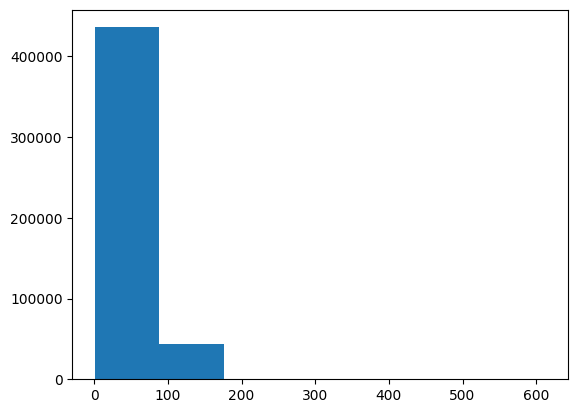

In [ ]:
# Check distribution
import matplotlib.pyplot as plt
plt.hist(char_lenghts, bins=7)

In [ ]:
# Find what character length covers 97% of sequences
output_seq_char_len = int(np.percentile(char_lenghts, 97))
output_seq_char_len

102

In [ ]:
# Get all keybord characters
import string
alphabet = string.ascii_lowercase + string.punctuation + string.digits
alphabet = len(alphabet)

In [ ]:
# Create a Char Vectorization
NUM_CHAR_TOKENS = alphabet + 2
char_vectorizer = tf.keras.layers.TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                                    standardize="lower_and_strip_punctuation",
                                                    output_sequence_length=output_seq_char_len,
                                                    name="char_vectorizer")
char_vectorizer.adapt(train_char_sentences)

In [ ]:
# Let's build our Char Embeddings
char_vocab = char_vectorizer.get_vocabulary()
print(f"Get 5 most used chars: {char_vocab[:5]}")
print(f"Get 5 least used chars: {char_vocab[-5:]}")

Get 5 most used chars: ['', '[UNK]', 'e', 'n', 'o']
Get 5 least used chars: ['²', '©', '\x84', '§', 'ª']


In [ ]:
# Let's create our char dataset
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_char_sentences, train_labels_one_hot))
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_char_sentences, val_labels_one_hot))

In [ ]:
# Creating our Char Embeddings
char_embeddings = tf.keras.layers.Embedding(input_dim=len(char_vocab),
                                             output_dim=56,
                                             mask_zero=True,
                                             name="char_embeddings")

# Create word embedding
inputs = tf.keras.Input(shape=[], dtype=tf.string)
use_embeddings = sentence_encoder(inputs)
outputs = layers.Dense(128, activation="relu")(use_embeddings)
token_model = tf.keras.Model(inputs, outputs)

# Create char embeddings
inputs = tf.keras.Input(shape=[1, ], dtype=tf.string)
char_vec = char_vectorizer(inputs)
char_embeddings = char_embeddings(char_vec)
outputs = layers.Bidirectional(layers.LSTM(64, activation="relu"))(char_embeddings)
char_model = tf.keras.Model(inputs, outputs)

# Concatenate the two models into 1.
char_embed_model = tf.keras.layers.Concatenate(name="char_embed_model", axis=1)([token_model.output, char_model.output])

# Add some optimization
x = layers.Dense(256, activation="relu")(char_embed_model)
dropout_layer = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation="softmax")(dropout_layer)
model_3 = tf.keras.Model(inputs=[token_model.input,
                                 char_model.input],
                                 outputs=outputs)

In [ ]:
model_3.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 102)                  0         ['input_3[0][0]']             
 rization)                                                                                        
                                                                                                  
 USE (KerasLayer)            (None, 512)                  0         ['input_2[0][0]']       

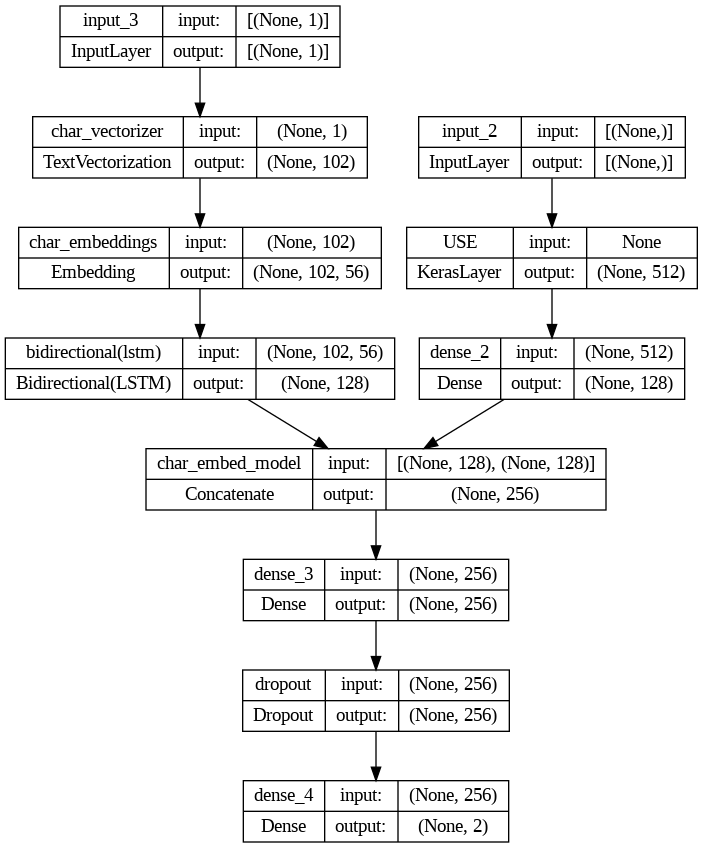

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_3, show_shapes=True)

In [ ]:
train_token_char_dataset = tf.data.Dataset.from_tensor_slices(((train_sentences, train_char_sentences), train_labels_one_hot))
val_token_char_dataset = tf.data.Dataset.from_tensor_slices(((val_sentences, val_char_sentences), val_labels_one_hot))


train_token_char_dataset = train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_token_char_dataset = val_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(lr=0.01),
                metrics=["accuracy"])

In [ ]:
# Fit the model

model_3_history = model_3.fit(train_token_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_token_char_dataset)),
                              epochs=3,
                              validation_data=[val_token_char_dataset],
                              validation_steps = int(0.1 * len(val_token_char_dataset)))

Epoch 1/3
1499/1499 [==============================] - 721s 476ms/step - loss: 0.5215 - accuracy: 0.7385 - val_loss: 0.5057 - val_accuracy: 0.7619
Epoch 2/3
1499/1499 [==============================] - 708s 472ms/step - loss: 0.5023 - accuracy: 0.7527 - val_loss: 0.5007 - val_accuracy: 0.7569
Epoch 3/3
1499/1499 [==============================] - 713s 476ms/step - loss: 0.4982 - accuracy: 0.7568 - val_loss: 0.4946 - val_accuracy: 0.7569


In [ ]:
# Evaluate our model
model_3_preds_probs = model_3.predict(val_token_char_dataset)
model_3_preds = tf.argmax(model_3_preds_probs, axis=1)

500/500 [==============================] - 28s 55ms/step


In [ ]:
model_3_results = calculate_results(val_labels_encoded, model_3_preds)
model_3_results

{'accuracy': 75.28132033008252,
 'precision': 0.7564722765750227,
 'recall': 0.7528132033008252,
 'f1': 0.7520171534974118}

### Save model_2 and model_3 (**optional**)



In [ ]:
## Uncomment for your needs

#model_3.save("model_3")
#model_2.save("model_2")
#
## Model_2
#!zip -r /content/model_2.zip /content/model_2
#
#from google.colab import files
#files.download("/content/model_2.zip")
#
## Model_3
#!zip -r /content/model_3.zip /content/model
#
#from google.colab import files
#files.download("/content/model_3.zip")

# Compare the results

In [ ]:
baseline_model_results, model_2_results, model_3_results

({'accuracy': 76.0440110027507,
  'precision': 0.7606563568777712,
  'recall': 0.7604401100275069,
  'f1': 0.7603682237045517},
 {'accuracy': 75.20630157539385,
  'precision': 0.7576280958230797,
  'recall': 0.7520630157539385,
  'f1': 0.7527134906260641},
 {'accuracy': 75.28132033008252,
  'precision': 0.7564722765750227,
  'recall': 0.7528132033008252,
  'f1': 0.7520171534974118})

In [ ]:
import pandas as pd

In [ ]:
# Compare the results
model_results = pd.DataFrame({"baseline_results": baseline_model_results,
                              "model_2_results": model_2_results,
                              "model_3_results": model_3_results})

model_results = model_results.transpose()
model_results["accuracy"] = model_results["accuracy"] / 100
model_results

,accuracy,precision,recall,f1
baseline_results,0.760440,0.760656,0.760440,0.760368
model_2_results,0.752063,0.757628,0.752063,0.752713
model_3_results,0.752813,0.756472,0.752813,0.752017


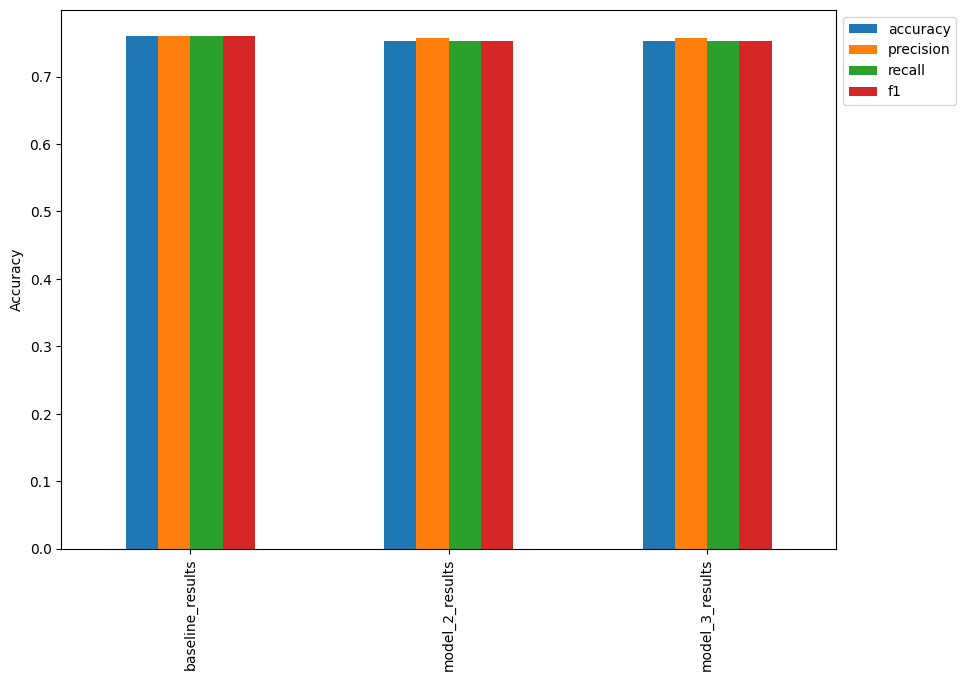

In [ ]:
# Plot the results
model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))
plt.ylabel("Accuracy")
plt.show()